# Decision Tree

# Basic Functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_data(target_column):
    file_path = '/Users/sanghyunkim/Desktop/CS 573 Final/cs573_final_proj/df_one_hot_encoded_normalized.csv'
    data = pd.read_csv(file_path)
    train_data = data[(data['Target']== '0') | (data['Target']== '1')] # Training data (rows labeled 0 and 1)
    X = train_data.drop(columns=['Target'])
    y = train_data['Target'].astype(int)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


# Train and Evaluation

In [2]:
def train_and_evaluate(X_train, X_valid, X_test, y_train, y_valid, y_test, max_depths, min_samples_splits):
    results_depth = []
    results_split = []

    # Tune max_depth
    for depth in max_depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_valid_pred = model.predict(X_valid)
        y_test_pred = model.predict(X_test)

        valid_accuracy = round(accuracy_score(y_valid, y_valid_pred), 4)
        test_accuracy = round(accuracy_score(y_test, y_test_pred), 4)

        results_depth.append((depth, valid_accuracy, test_accuracy))
        print(f"Max Depth: {depth}, Validation Accuracy: {valid_accuracy}, Test Accuracy: {test_accuracy}")

    # Tune min_samples_split
    for split in min_samples_splits:
        model = DecisionTreeClassifier(min_samples_split=split, random_state=42)
        model.fit(X_train, y_train)
        y_valid_pred = model.predict(X_valid)
        y_test_pred = model.predict(X_test)

        valid_accuracy = round(accuracy_score(y_valid, y_valid_pred), 4)
        test_accuracy = round(accuracy_score(y_test, y_test_pred), 4)

        results_split.append((split, valid_accuracy, test_accuracy))
        print(f"Min Samples Split: {split}, Validation Accuracy: {valid_accuracy}, Test Accuracy: {test_accuracy}")

    # Convert results to DataFrame
    results_depth_df = pd.DataFrame(results_depth, columns=["Max Depth", "Validation Accuracy", "Test Accuracy"])
    results_split_df = pd.DataFrame(results_split, columns=["Min Samples Split", "Validation Accuracy", "Test Accuracy"])

    # Plot results
    plot_tuning_results(results_depth_df, x_col="Max Depth", title="Max Depth vs Accuracy")
    plot_tuning_results(results_split_df, x_col="Min Samples Split", title="Min Samples Split vs Accuracy")



# Plotting

In [3]:
def plot_tuning_results(results_df, x_col, title):
    plt.figure(figsize=(10, 6))
    plt.plot(results_df[x_col], results_df["Validation Accuracy"], marker="o", label="Validation Accuracy")
    plt.plot(results_df[x_col], results_df["Test Accuracy"], marker="o", label="Test Accuracy")
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

Max Depth: 3, Validation Accuracy: 0.9081, Test Accuracy: 0.8889
Max Depth: 5, Validation Accuracy: 0.9136, Test Accuracy: 0.8944
Max Depth: 7, Validation Accuracy: 0.904, Test Accuracy: 0.875
Max Depth: 9, Validation Accuracy: 0.8903, Test Accuracy: 0.8694
Max Depth: None, Validation Accuracy: 0.8697, Test Accuracy: 0.85
Min Samples Split: 2, Validation Accuracy: 0.8697, Test Accuracy: 0.85
Min Samples Split: 5, Validation Accuracy: 0.8807, Test Accuracy: 0.8528
Min Samples Split: 10, Validation Accuracy: 0.8889, Test Accuracy: 0.8583
Min Samples Split: 20, Validation Accuracy: 0.8916, Test Accuracy: 0.8583


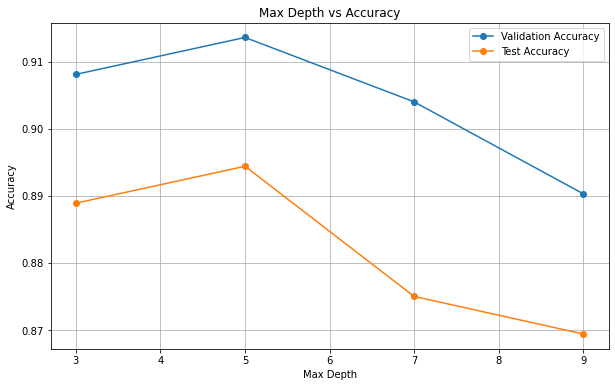

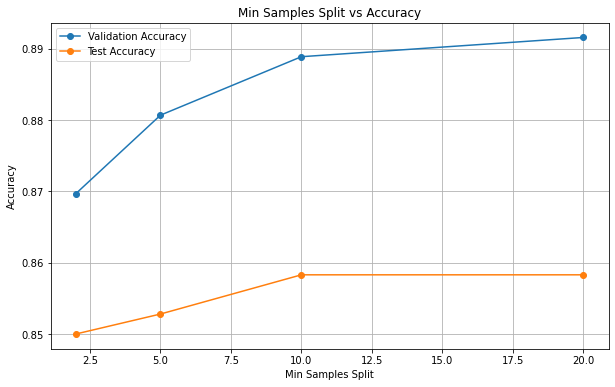

In [4]:
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(target_column="Target")

max_depths = [3, 5, 7, 9, None]
min_samples_splits = [2, 5, 10, 20]

train_and_evaluate(X_train, X_valid, X_test, y_train, y_valid, y_test, max_depths, min_samples_splits)


# Chi-Square Pruning Decision Tree

In [23]:
class ChiSquarePrunedTree:
    def __init__(self, max_depth=None, min_samples_split=2, alpha=0.05):
        self.tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        self.alpha = alpha

    def fit(self, X, y):
        self.tree.fit(X, y)
        self.X = X.values if isinstance(X, pd.DataFrame) else X
        self.y = y

    def prune(self):
        tree = self.tree.tree_
        n_nodes = tree.node_count
        children_left = tree.children_left
        children_right = tree.children_right
        feature = tree.feature
        threshold = tree.threshold

        def prune_node(node):
            if children_left[node] == -1 and children_right[node] == -1:
                return

            left = children_left[node]
            right = children_right[node]

            if left == -1 or right == -1:
                return

            left_samples = self.y[self.X[:, feature[node]] <= threshold[node]]
            right_samples = self.y[self.X[:, feature[node]] > threshold[node]]

            contingency_table = np.array([
                [np.sum(left_samples == c), np.sum(right_samples == c)] for c in np.unique(self.y)
            ])

            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            if p_value > self.alpha:
                children_left[node] = -1
                children_right[node] = -1

            prune_node(left)
            prune_node(right)

        prune_node(0)

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            return self.tree.predict(X)
        else:
            raise ValueError("Input data X must be a pandas DataFrame with feature names.")

# Load dataset
df = pd.read_csv('/Users/sanghyunkim/Desktop/CS 573 Final/cs573_final_proj/df_one_hot_encoded_normalized.csv')
train_data = df[(df['Target'] == '0') | (df['Target'] == '1')]  # Training data (rows labeled 0 and 1)
X = train_data.drop(columns=['Target'])
y = train_data['Target'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

chi_square_pruned_tree = ChiSquarePrunedTree(max_depth=5, min_samples_split=5, alpha=0.1)

In [24]:
pruned_tree = ChiSquarePrunedTree(max_depth=5, alpha=0.05)
pruned_tree.fit(X_train, y_train)
pruned_tree.prune()

y_pred = pruned_tree.predict(X_test)
print("Accuracy after pruning:", round(accuracy_score(y_test, y_pred), 4))

Accuracy after pruning: 0.9187


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def evaluate_hyperparameter(X, y, param_name, param_values, fixed_params, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    results = []
    for value in param_values:
        params = fixed_params.copy()
        params[param_name] = value

        tree = ChiSquarePrunedTree(
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            alpha=params['alpha']
        )
        tree.fit(X_train, y_train)
        tree.prune()

        y_pred_test = tree.predict(X_test)
        y_pred_train = tree.predict(X_train)

        test_accuracy = accuracy_score(y_test, y_pred_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)

        results.append({
            param_name: value,
            'Validation Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy
        })

    return pd.DataFrame(results)

def plot_tuning_results(results_df, x_col, title):
    plt.figure(figsize=(10, 6))
    plt.plot(results_df[x_col], results_df["Validation Accuracy"], marker="o", label="Validation Accuracy")
    plt.plot(results_df[x_col], results_df["Test Accuracy"], marker="o", label="Test Accuracy")
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


In [26]:
fixed_params = {
    'max_depth': 5,
    'min_samples_split': 10,
    'alpha': 0.05
}

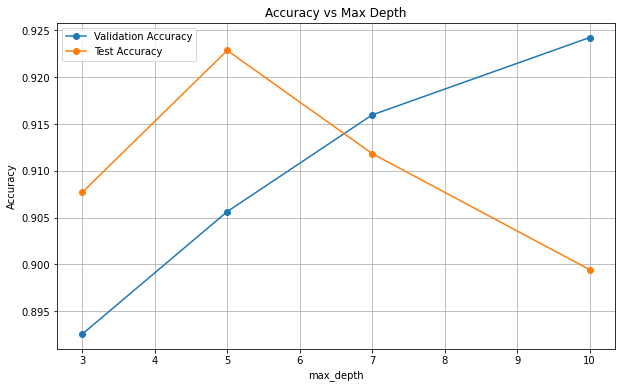

In [27]:
# max_depth 
max_depth_values = [3, 5, 7, 10]
max_depth_results = evaluate_hyperparameter(X, y, 'max_depth', max_depth_values, fixed_params)
plot_tuning_results(max_depth_results, 'max_depth', "Accuracy vs Max Depth")


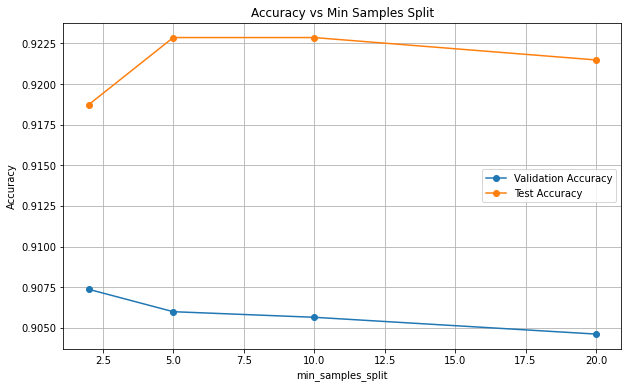

In [28]:
# min_samples_split
min_samples_split_values = [2, 5, 10, 20]
min_samples_split_results = evaluate_hyperparameter(X, y, 'min_samples_split', min_samples_split_values, fixed_params)
plot_tuning_results(min_samples_split_results, 'min_samples_split', "Accuracy vs Min Samples Split")


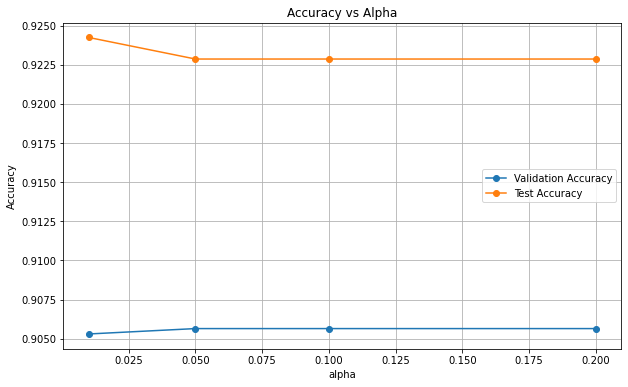

In [29]:
# alpha 
alpha_values = [0.01, 0.05, 0.1, 0.2]
alpha_results = evaluate_hyperparameter(X, y, 'alpha', alpha_values, fixed_params)
plot_tuning_results(alpha_results, 'alpha', "Accuracy vs Alpha")


In [30]:
best_max_depth = max_depth_results.sort_values(by='Test Accuracy', ascending=False).iloc[0]
best_min_samples_split = min_samples_split_results.sort_values(by='Test Accuracy', ascending=False).iloc[0]
best_alpha = alpha_results.sort_values(by='Test Accuracy', ascending=False).iloc[0]


print(f"Best Max Depth: {best_max_depth}")
print("\n================\n")
print(f"Best Min Samples Split: {best_min_samples_split}")
print("\n================\n")
print(f"Best Alpha: {best_alpha}")

Best Max Depth: max_depth              5.000000
Validation Accuracy    0.905647
Test Accuracy          0.922865
Name: 1, dtype: float64


Best Min Samples Split: min_samples_split      5.000000
Validation Accuracy    0.905992
Test Accuracy          0.922865
Name: 1, dtype: float64


Best Alpha: alpha                  0.010000
Validation Accuracy    0.905303
Test Accuracy          0.924242
Name: 0, dtype: float64


In [31]:
def evaluate_best_combination(X, y, best_max_depth, best_min_samples_split, best_alpha):
    fixed_params = {
        'max_depth': int(best_max_depth['max_depth']),  
        'min_samples_split': int(best_min_samples_split['min_samples_split']),
        'alpha': float(best_alpha['alpha'])  
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    best_tree = ChiSquarePrunedTree(
        max_depth=5,
        min_samples_split=20,
        alpha=0.05
    )
    
    best_tree.fit(X_train, y_train)
    best_tree.prune()

    y_pred_test = best_tree.predict(X_test)
    y_pred_train = best_tree.predict(X_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    return {
        'Validation Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Best Parameters': fixed_params
    }

In [32]:
best_combination_results = evaluate_best_combination(
    X, y, best_max_depth, best_min_samples_split, best_alpha
)

print("Best Combination Results:")
print(f"Validation Accuracy: {best_combination_results['Validation Accuracy']:.6f}")
print(f"Test Accuracy: {best_combination_results['Test Accuracy']:.6f}")
print("Best Parameters:")
print(best_combination_results['Best Parameters'])

Best Combination Results:
Validation Accuracy: 0.904614
Test Accuracy: 0.921488
Best Parameters:
{'max_depth': 5, 'min_samples_split': 5, 'alpha': 0.01}
